In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions
using LsqFit, TwoFAST, LaTeXStrings

In [3]:
tab_CLASS_pk = readdlm("../data/WideA_ZA_pk.dat", comments=true);
CLASS_ks = convert(Vector{Float64}, tab_CLASS_pk[:,1]);
CLASS_k_min, CLASS_k_max = CLASS_ks[begin], CLASS_ks[end]
CLASS_pks = convert(Vector{Float64}, tab_CLASS_pk[:,2]);
CLASS_spline = Spline1D(CLASS_ks, CLASS_pks);

In [4]:
tab_casto_pk = readdlm("../test/datatest/file_pk.txt")
casto_ks = tab_casto_pk[:,1]
casto_k_min, casto_k_max = casto_ks[begin], casto_ks[end]
casto_pks = tab_casto_pk[:,2]
casto_spline = Spline1D(casto_ks, casto_pks);

In [5]:
CLASS_ks

421-element Vector{Float64}:
  2.056154633223e-7
  2.153058215655e-7
  2.254528723228e-7
  2.360781388492e-7
  2.472041587598e-7
  2.588545318342e-7
  2.71053970076e-7
  2.838283501291e-7
  2.972047681664e-7
  3.112115973638e-7
  3.258785480842e-7
  3.412367308964e-7
  3.573187225651e-7
  ⋮
 12.18870593602
 12.7631419494
 13.36465029804
 13.9945068618
 14.65404765088
 15.34467163974
 16.06784373443
 16.82509787995
 17.61804031384
 18.44835297334
 19.3177970629
 20.22821679002

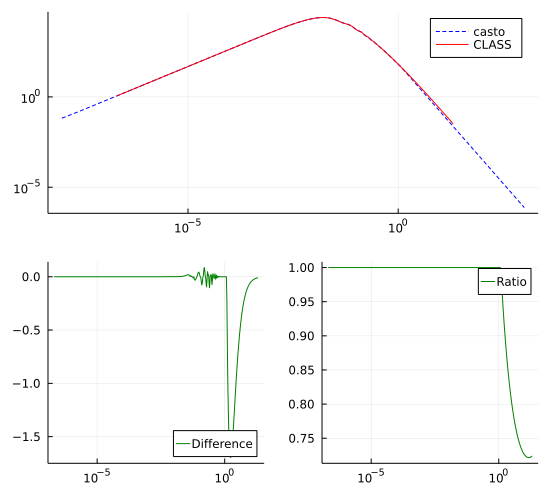

In [6]:
spline = casto_spline

p1 = plot([casto_ks, CLASS_ks] , 
    [casto_pks, CLASS_pks],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["casto" "CLASS"])

p2 = plot(CLASS_ks, spline.(CLASS_ks) .- CLASS_pks, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(CLASS_ks, spline.(CLASS_ks) ./ CLASS_pks, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

In [27]:
GaPSE.power_law_from_data(CLASS_ks, CLASS_pks, 
    [1.0, 1.0, 0.0], 3e-7, 1e-3; con=true)

(0.9484241049570445, 2.7372501643459336e6, -1.7393919875070682)

In [28]:
GaPSE.power_law_from_data(CLASS_ks, CLASS_pks, 
    [-3.0, 1.0, 1.0], 1e0, 1e1; con=true)

(-2.3577212862162944, 64.91482750176814, -0.19722704747012276)

In [37]:
GaPSE.power_law_from_data(casto_ks, casto_pks, 
    [1.0, 1.0, 0.0], 1e-5, 1e-4; con=true)

(0.9596752456515256, 3.0028876681516273e6, -0.033993120701608814)

In [36]:
GaPSE.power_law_from_data(casto_ks, casto_pks, 
    [-3.0, 1.0, 0.0], 1e0, 1e1; con=true)

(-2.554181809327827, 66.06348251423428, -0.17132126017325625)

In [11]:
function expanded_IPS(ks, pks; k_in = 1e-8, k_end = 3e3, con = false)
     k1, k2 = 1e-6, 1e-4
     k3, k4 = 1e1, 2e1

     p0_beg = con ? [1.0, 1.0, 1.0] : [1.0, 1.0]
     p0_end = con ? [-3.0, 1.0, 1.0] : [-3.0, 1.0]

     #=
     si_beg, b_beg, a_beg, step_beg, fac_beg =  ks[begin]>k_in ? 
         (power_law_from_data(ks, pks, p0_beg, k1, k2; con=con)..., 
         ks[begin+1] - ks[begin] ,  ks[begin] / ks[begin+1]) :
         (nothing, nothing, nothing, nothing, nothing)


     si_end, b_end, a_end, step_end, fac_end = ks[end]<k_end ?  
         (power_law_from_data(ks, pks, p0_end, k3, k4; con=con)... ,
         ks[end] - ks[end-1], ks[end] / ks[end-1]) :
         (nothing, nothing, nothing, nothing, nothing)

     println("$si_beg , $b_beg , $a_beg , $step_beg , $fac_beg")
     println("$si_end , $b_end , $a_end , $step_end , $fac_end")
     =#

     new_left_ks, new_left_pks =
          ks[begin] > k_in ?
          expand_left_log(ks, pks; lim = k_in, fit_min = k1,
               fit_max = k2, p0 = p0_beg, con = con) : (nothing, nothing)

     new_right_ks, new_right_pks =
          ks[end] < k_end ?
          expand_right_log(ks, pks; lim = k_end, fit_min = k3,
               fit_max = k4, p0 = p0_end, con = con) : (nothing, nothing)


     new_ks, new_pks =
          if !isnothing(new_left_ks) && !isnothing(new_right_ks)
               (vcat(new_left_ks, ks[k1.<ks.<k4], new_right_ks),
                    vcat(new_left_pks, pks[k1.<ks.<k4], new_right_pks))
          elseif isnothing(new_left_ks) && !isnothing(new_right_ks)
               (vcat(ks[ks.<k4], new_right_ks),
                    vcat(pks[ks.<k4], new_right_pks))
          elseif !isnothing(new_left_ks) && isnothing(new_right_ks)
               (vcat(new_left_ks, ks[k1.<ks]),
                    vcat(new_left_pks, pks[k1.<ks]))
          else
               (ks, pks)
          end

     return new_ks, new_pks
end

expanded_IPS (generic function with 1 method)

In [12]:
ks, pks = expanded_IPS(CLASS_ks, CLASS_pks; k_in=1e-12, k_end=3e4)
plot(ks, pks, xaxis=:log, yaxis=:log)

LoadError: UndefVarError: expand_left_log not defined

In [13]:
spline = Spline1D(ks, pks)

p1 = plot([casto_ks, casto_ks] , 
    [casto_pks, spline.(casto_ks)],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["casto" "CLASS"])

p2 = plot(casto_ks, spline.(casto_ks).- casto_pks, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(casto_ks, spline.(casto_ks) ./ casto_pks, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

LoadError: UndefVarError: ks not defined

In [14]:
ks[begin]

LoadError: UndefVarError: ks not defined

In [15]:
ks = CLASS_ks
pks = CLASS_pks
k1, k2 = 1e-6, 1e-4
k3, k4 = 1e1, 2e1
k_in, k_end = 1e-10, 3e3

N_k1 = findfirst(x->x>k1, ks) 
N_k4 = findfirst(x->x>k4, ks) - 1

p0_beg = true ? [1.0, 1.0, 1.0] : [1.0, 1.0]

si_beg, b_beg, a_beg, step_beg, fac_beg =  ks[begin]>k_in ? 
    (power_law_from_data(ks, pks, p0_beg, k1, k2; con=true)..., 
    ks[begin+1] - ks[begin] ,  ks[begin] / ks[begin+1]) :
    (nothing, nothing, nothing, nothing, nothing)


println("$si_beg , $b_beg , $a_beg , $step_beg , $fac_beg")

new_left_ks = ks[begin]>k_in ?
    #(new_left_temp = ks[N_k1]  .- step_beg .* cumsum([fac_beg^i for i in 1:1000])
    (new_left_temp = 10 .^ range(log10(k_in), log10(ks[N_k1]), step=-log10(fac_beg));
    reverse(unique(new_left_temp[new_left_temp .> k_in]))) : nothing

new_left_pks = isnothing(new_left_ks) ? nothing :
    [power_law(k, si_beg, b_beg, a_beg) for k in new_left_ks] 

new_left_ks, new_left_pks

LoadError: UndefVarError: power_law_from_data not defined

In [16]:
10 .^range(log10(k_in), log10(ks[N_k1]), step=-log10(fac_beg))

LoadError: UndefVarError: fac_beg not defined

In [17]:
x_min = 1e0
x_max = 1e2

xs = CLASS_ks[x_min.< CLASS_ks .< x_max]
first_ys = CLASS_pks[x_min.< CLASS_ks .< x_max]
sec_ys = casto_spline.(xs)

first_sis = spectral_index(xs, first_ys; N=2, con=false)
sec_sis = spectral_index(xs, sec_ys; N=2, con=false)


p1 = scatter( [xs, xs], [first_sis, sec_sis] ,
    xscale=:log10, #yscale=:log10,
    label=["CLASS SI" "Casto SI"], color=[:blue :red], 
    markersize = [1 1], markerstrokewidth=[0 0] )

p2 = plot(xs, sec_sis .- first_sis, 
    xscale=:log10,
    label="Difference", lc=:green, legend=:bottomright)

p3 = plot(xs, sec_sis ./ first_sis, xscale=:log10, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

LoadError: UndefVarError: spectral_index not defined

In [18]:
N = 2
#si_begin, si_end = CLASS_sis[begin], CLASS_sis[end];
casto_sis = spectral_index(casto_ks, casto_pks; N=N, con=true)
CLASS_sis = spectral_index(CLASS_ks, CLASS_pks; N=N, con=true);

LoadError: UndefVarError: spectral_index not defined

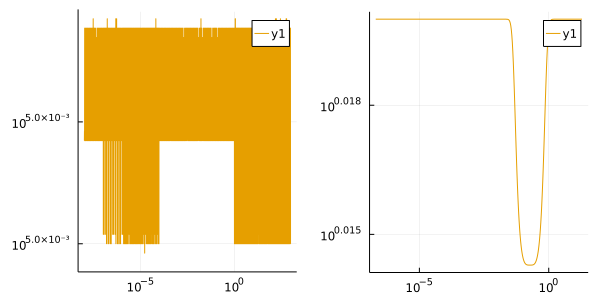

GKS: Possible loss of precision in routine SET_WINDOW


In [19]:
casto_xs = [casto_ks[i+1]/casto_ks[i] for i in 1:length(casto_ks)-1 ]
p1 = plot(casto_ks[begin:(end-1)], casto_xs, xaxis=:log, yaxis=:log)
CLASS_xs = [CLASS_ks[i+1]/CLASS_ks[i] for i in 1:length(CLASS_ks)-1 ]
p2 = plot(CLASS_ks[begin:(end-1)], CLASS_xs, xaxis=:log, yaxis=:log)

plot(p1,p2, size=(600, 300))

In [20]:
CLASS_si_of_sis = spectral_index(CLASS_ks[begin+N:end-N], CLASS_sis; 
                        N=N)[begin+N:end-N]
new_CLASS_ks = CLASS_ks[(begin +2*N):(end - 2*N)];

LoadError: UndefVarError: spectral_index not defined

In [21]:
x_min = 1e0
x_max = 1e3

scatter(new_CLASS_ks[x_min.< new_CLASS_ks .< x_max], 
        CLASS_si_of_sis[x_min.< new_CLASS_ks .< x_max], 
    xscale=:log10, #yscale=:log10,
    label="CLASS SI of SI", color=:red, 
    markersize = 1, markerstrokewidth=0)

LoadError: UndefVarError: new_CLASS_ks not defined

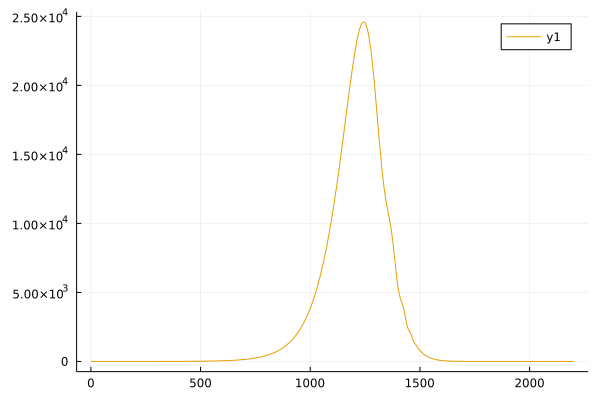

In [22]:
f = casto_ks[begin] / casto_ks[end]
xs = 
ys = casto_pks 
plot(xs)#, ys, xaxis=:log, yaxis=:log)

In [23]:
function derivate_point(xp, yp, x1, y1, x2, y2)
     l2, l1 = (x2 - xp), (xp - x1)
     m2, m1 = (y2 - yp) / l2, (yp - y1) / l1
     res = (m1*l2 + m2*l1) / (l1+l2)
     #println(res)
     return res
end

function derivate_vector(xs, ys; N::Integer = 1)
     if N == 1
          real_vec = [derivate_point(xs[i], ys[i], xs[i-1], ys[i-1], xs[i+1], ys[i+1])
                      for i in (N+1):(length(xs)-N)]
          return vcat(real_vec[begin], real_vec, real_vec[end])
     elseif N > 1
          vec = [derivate_point(xs[i], ys[i], xs[i-j], ys[i-j], xs[i+j], ys[i+j])
                 for i in (N+1):(length(xs)-N), j in 1:N]
          real_vec = [sum(row) / N for row in eachrow(vec)]
          return vcat([real_vec[begin] for i in 1:N], real_vec,
               [real_vec[end] for i in 1:N])
     else
          throw(ErrorException(" N must be an integer >1, not $N!"))
     end
end

function spectral_index(xs, ys; N::Integer = 1, con = false)
     derivs = derivate_vector(xs, ys; N = N)

     if con == false
          return [x * d / y for (x, y, d) in zip(xs, ys, derivs)]
     else
          sec_derivs = derivate_vector(xs, derivs; N = N)
          vec = [x * d2 / d for (x, d, d2) in zip(xs, derivs, sec_derivs)]
          return vec .+ 1.0
     end
end


function mean_spectral_index(ixs, ys; N::Integer = 1, con = false)
     vec = spectral_index(ixs, ys; N = N, con = con)[begin+2*N:end-2*N]
     return sum(vec) / length(vec)
end

mean_spectral_index (generic function with 1 method)

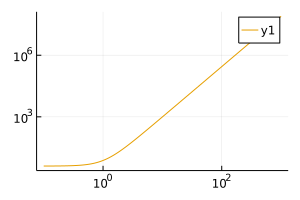

In [24]:
is = 10 .^ range(-1, 3, 100)
xs = [4.0 + 3.5*i^2.45 for i in is]
plot(is, xs, size=(300, 200), xaxis=:log, yaxis=:log)

In [25]:
mean_spectral_index(is, xs; con=true)

2.449482783212668